# Perceiver Autoencoder

In this notebook, I prototype the **full** version of the Perceiver autoencoder. This includes the training loop and any data management that needs to occur with this. Disk-memory-GPU optimization of data flow will not be performed, however. 

**Goals:**
Fully adjustable + parameterizable Perceiver for Predictive Coding.
 - **Encoder**: Adjustable encoder shape, # re-exposures as data is compressed. 
	 - Query = current latent state; key-values = input byte array. 
	 	 - Re-exposures: query = current latent state estimate; key-values = input byte array.
		 - **Option**: residual connections around TF blocks.  
		 - **Option**: use different block types for each block after the first. 
	 - Let's avoid having a bunch of intermediate {#token, token dim} sizes between the original byte array and the final latent state. 
	 - The only adjustment should be the # re-exposures -- i.e., the number of different $\mathbb{R}^{(M \times D)} \to \mathbb{R}^{(N\times C)}$ encoders there are that re-query the byte array using the current latent estimate. 
 - **Latent-latent**: Number of distinct blocks, number of block repeats between new information exposure. 
 - **Decoder**: Similar to encoder, queries = positional codes we want to reconstruct, key-values = latent matrix. 
	 - Avoid intermediate dimensionailties. 
	 - For repeated querying, do we use query = current reconstruction, key-value = latent matrix? 
	 	 - **Optional**: Can have residual connections, too!
		 - **Optional**: use the same blocks for every step of re-exposure. 


## Pseudocode 

```python
class Model: 
	governing class vars: 
		encoder = [several TF Blocks]
		num_distinct_encoder = [int]
		num_total_encoder = [int]
		residual_encoder = [bool]
		
		latent_evolver = [several TF Blocks]
		num_distinct_latent = [int]
		num_total_latent_cycles = [int] # if this is a 2-tuple: we randomly select some # of latent cycles in that range. 
		
		
		decoder = [several TF Blocks]
		num_distinct_decoder = [int]
		num_total_decoder = [int]	
		residual_decoder = [bool]

	class state vars: 
		latent_state = [TF variable, learnable initial pos code]

	function encode(input_tokens, encoder_type=0): 
		""" `encoder_type` is an integer. Change this to use different encoders 
		(e.g., video vs. audio vs. text encoder). 
		"""
		...

	function evolve_latent(): 
		...

	function decode(positional_codes, decoder_type=0):
		...


	function test(new_datum): 
		""" Basically just `call` but it won't incorporate the new datum into
		the latent state. It will also add the test performance to the model's 
		`test loss` records.  
		"""
		...

	function call(new_datum, return_latent=False, encoder_type=0):
		""" Given some new patches, we calculate the "surprise" 
			then incorporate the data into the latent state. 

			We finally return the surprise value, just for metric tracking. 
		"""
		# Computing surprise		
		predicted_input = decode(new_datum.positional_codes, decoder_type=encoder_type)
		new_loss = loss(predicted_input, new_datum.tokens) 
	
		# Incorporating new info -> latent state, performing latent evolutions.
		encode(new_datum, encoder_type=encoder_type)

		evolve_latent()

		# returning values 
		if return_latent: 
			return new_loss, self.latent
		else:
			return new_loss	
```

## 0: Imports & Data Acquisition

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio

2022-10-20 18:00:49.982324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 18:00:50.316315: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 18:00:50.434434: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 18:00:51.593808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
## GPU Setup
physical_devices = tf.config.list_physical_devices("GPU")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
## Get some data 
# Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 20
output_size = (120, 180)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


  0%|          | 0/16 [00:00<?, ?it/s]2022-10-20 18:00:53.253294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 18:00:54.627567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18523 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-10-20 18:00:54.628686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:68:00.0, compute capability: 8.6
100%|██████████| 16/16 [00:03<00:00,  5.22it/s]


Making patches from Videoset...
Making the flat patch set...
Adding codes to the PatchSet...
Flattening the coded + patched dataset...


# 1: Custom Layers

To keep the model as modular as possible, I will define custom layers for the 
`encoder`, `decoder`, and `latent_evolver` blocks. While it may seem 
inconvenient due to unfamiliarity with the keras Layers customization API, 
it should help by facilitating debugging, future weight exchanges between 
models, and expansion. 

I will also document any design decisions here. Hopefully this 
will be helpful during the writing phase of the project. 

## 1a: Transformer Layers

Before considering encoder/decoder/latent evolver blocks, we need to define a 
good Transformer block abstraction. Recall the operations of a transformer 
block: Given input `query_in, key_in`, 
 1. `mha_out` is calculated. The query is added as a residual connection, and a 
	`layernorm` is applied. 
 2. `feedforward_net` is applied to the MHA's output. Residual connection is 
	added around the feedforward network and a `layernorm` is applied again.  

Notably, we are interested in reprojecting the tokens into vastly different 
sizes. The number of input tokens and their dimensionalities may not always 
match the number of output tokens and their dimensionalities. 

This introduces an important question: If we desire a different output dimensionality or 
number of tokens, where and how do we do this within a transformer layer? 

__Token dimensionality changes__: This can be accomplished in a very
straight-forward manner by changing the output dimension of the
`feedforward_net`.  However, this means that the output token dimensionality
won't match the intermediate token dimensionality that came out of the MHA
layer! The residual connection around the `feedforward_net` is no longer
possible. 

We could move the problem back one block by changing the `output_dim` of the MHA
layer (i.e., output values are calculated through a dimension-expanding
projection of the input keys). This is doesn't solve much, though, because 
now the residual connection around the MHA layer is no longer possible!

Overall, it's simpler and cleaner to just change the output dimensionality. 
There's probably some interesting theory you could do about this question, but 
the point is that it preserves the most about the original transformer block 
design AND it's really easy to implement. 

__Number of token changes__: To force the number of tokens in the output to 
NOT match the number of tokens in the input, you need to use a `query_in` that 
has the desired number of tokens. 

The queries can be thought to ask, "what value should I take on next?". They 
dictate the number of tokens in the output, and usually the output also matches 
their dimensionality. Meanwhile, keys can be thought to "give information" in 
order to inform the update to the queries. 

In [4]:
class TFLayer(keras.layers.Layer):
	def __init__(self, output_token_dim=None, n_heads=15, key_dim=15, mha_dropout=0.0): 
		""" Transformer block. Input -> MHA -> residual, layernorm -> 
				FFN -> residual (if possible). 

		The residual connections can only sometimes work. If the MHA step produces 
		tokens of a dimensionality DIFFERENT than the dimensionality of the 
		query tokens, we can't perform the residual step. 

		kwargs: 
			`output_dim`: 	Dimensionality of the output tokens. 
							If unspecified, defaults to the input token dimensionality
							(set during the `build()` function on first layer call). 
							The output will generally have the size [num_tokens, output_dim].
			`n_heads`:		Number of heads in the MHA layer. 
			`key_dim`:		Dimensionality of keys within each MHA layer. 
			`mha_dropout`: 	Dropout rate for the multihead attention layer. 
		"""
		super(TFLayer, self).__init__() 

		self.output_token_dim = output_token_dim

		# whether we perform the final residual; updated in `build() based on whether the output token dimensionality 
		self.ffn_residual = True 
		self.input_token_dim = None # set during `build()`

		self.MHA = keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, dropout=mha_dropout)

		# We wait until `build` to construct our convolution layers.

		# Layernorms
		self.layer_norm_mha = tf.keras.layers.LayerNormalization()
		self.layer_norm_ffn = tf.keras.layers.LayerNormalization()

	def build(self, call_shapes): 
		self.MHA._build_from_signature(*call_shapes)
		q_shape, k_shape = call_shapes

		input_dim = q_shape[-1]
		self.input_token_dim = input_dim

		self.conv1 = keras.layers.Conv1D(input_dim*4, 1, activation="relu")

		# if not specified, the output tokens will be the same size as the input token size.
		if self.output_token_dim == None:
			self.output_token_dim = input_dim 
		
		if not (self.output_token_dim == input_dim): 
			self.ffn_residual = False

		self.conv2 = keras.layers.Conv1D(self.output_token_dim, 1, activation="linear") 

	def call(self, kv_list, verbose=False): 
		""" Invokes the transformer block on the given queries and keys. 
		"""
		queries, keys = kv_list

		# Multihead attention sub-block.
		mha_out = self.MHA(queries, keys)
		mha_out = self.layer_norm_mha(mha_out + queries) # residual + layernorm

		# FFN sub-block
		ffn1_out = self.conv1(mha_out)
		ffn2_out = self.conv2(ffn1_out)
		if self.ffn_residual:
			ffn2_out += mha_out # performing residual if the out_dim == in_dim
		return self.layer_norm_ffn(ffn2_out) # final layernorm

In [5]:
## Testing out the TF layer, making sure everything's in order. 
tfl = TFLayer(output_token_dim=400)
B = 10
num_Q = 31
dim_Q = 20
Q_in = tf.random.uniform([B, num_Q, dim_Q])

num_K = 44
dim_K = 40
K_in = tf.random.uniform([B, num_K, dim_K])

output = tfl([Q_in, K_in])
print(output.shape == [B, num_Q, 400])

tfl = TFLayer(output_token_dim=None)
output = tfl([Q_in, K_in])
print(output.shape == Q_in.shape)

2022-10-20 18:01:06.410918: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


True
True


2022-10-20 18:01:07.123784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


## 1b: Encoder Layer 

__Operation__: The encoder layer is responsible for mapping some new high
dimensional information (input) and the existing low-dimensionality latent space
into an updated verison of the latent state. 

To accomplish this, we leverage principles from the Perceiver paper: 
 1. High-dim to low-dim transformation, then a bunch of low-dim to low-dim 
 transformations to perform efficient processing. 
 2. "Re-exposure" of the low-dimensional representation to the high-dim input 
 by assigning `query` := low-dim representation, `key-values` := high-dim 
 input. 

We are also interested in investigation the applicability of the following
ideas: 
 1. Prediction error/loss based on incoming new high-dim information (cf.
 "surprise" in Friston's free energy). 
 2. Random selection of tokens from input data to *actually* expose to the
 model.
 3. Random "wait times" (in terms of latent cycles) between subjecting the model
 to new information/re-exposing to previously seen information. 
 4. Multiple modalities of information being input AND predicted, randomly 
 rotated between (each has its own decoder but feeds into the same latent space).


__Where does initial `latent` query value come from?__ Overall, it's going to be 
far easier to have the top-level `PerceiverAE` model supply this information. 
The alternative involves coordinating memory clearing/altering operations 
between layers, which seems hard to keep track of. 

In [6]:
# Test: how to randomly sample from batches of data? 

X = tf.constant([[1, 2], [3, 4], [5, 6]], dtype=tf.float32)
selector = tf.random.uniform([3])
msk = selector > 0.5
Y = tf.boolean_mask(X, msk, axis=0)
print("X, Y, msk", X, Y, msk)

X, Y, msk tf.Tensor(
[[1. 2.]
 [3. 4.]
 [5. 6.]], shape=(3, 2), dtype=float32) tf.Tensor(
[[3. 4.]
 [5. 6.]], shape=(2, 2), dtype=float32) tf.Tensor([False  True  True], shape=(3,), dtype=bool)


In [7]:
class PAE_Encoder(keras.layers.Layer):
	def __init__(self, n_blocks, p_droptoken=0.5, re_droptoken=True, 
			tfblock_residual=True, n_heads=15, key_dim=15, mha_dropout=0.0): 
		""" 		
		Perceiver AE encoder layer. Queries during the call should be the 
		current `latent` state, and the key-values should be the incoming 
		byte array.

		The encoder sequentially re-queries the incoming byte array using the 
		latent state. The latent state used for re-querying is summed with 
		the result of each block, then the layernorm is taken (i.e., residual 
		+ layernorm). 

		args: 
			`n_heads`, `key_dim`, `mha_dropout`: Params uniformly applied to all transformer 
							blocks. 
			`n_blocks`: 	Number transformer blocks performing successive 
							requerying of the input. 
			`p_droptoken`: 	Portion of tokens to MAINTAIN from the input. 
			`re_droptoken`: Do we reselect the dropped tokens every time we 
							successively re-query the input? 
		kwargs: 
			`output_dim`: 	Dimensionality of the output tokens. 
		"""
		super(PAE_Encoder, self).__init__() 

		# Recording parameters. 
		self.n_blocks = n_blocks
		self.p_droptoken = p_droptoken
		self.re_droptoken = re_droptoken
		self.tfblock_residual = tfblock_residual

		self.n_heads = n_heads
		self.key_dim = key_dim
		self.mha_dropout = mha_dropout

		# Component layers
		self.tf_layers	 = [TFLayer(n_heads=self.n_heads, key_dim=self.key_dim, mha_dropout=self.mha_dropout) for i in range(self.n_blocks)]
		self.layer_norms = [tf.keras.layers.LayerNormalization() for i in range(self.n_blocks)]


	def call(self, kv_list, no_drop=False,  verbose=False): 
		""" Invokes the encoder module on a latent state and an input array. 

		args: 
			`kv_list`: 		Tuple or list [current_latent, input_array]
							current_latent.shape = [batch_size, N, C]
							input_array.shape    = [batch_size, M, D]
		"""
		latent, input_byte_array = kv_list

		# Length = # tokens in input
		if not no_drop:
			droptoken_mask = tf.random.uniform([input_byte_array.shape[1]]) < self.p_droptoken
			current_input = tf.boolean_mask(input_byte_array, droptoken_mask, axis=1)
		else: 
			current_input = input_byte_array

		print("Initial input size: ", input_byte_array.shape)
		print("Sampled input size: ", current_input.shape)

		# iterating through: 
		for i in range(self.n_blocks):
			assert current_input.shape[1] > 0, "Random sampling failed!"

			latent_ = self.tf_layers[i]([latent, current_input])

			# If we are applying tfblock_residuals: 
			if self.tfblock_residual: 
				latent_ = self.layer_norms[i](latent_ + latent)

			latent = latent_

			# If we are going to reselect tokens from the input for every 
			# re-querying: 
			if self.re_droptoken and not no_drop: 
				droptoken_mask = tf.random.uniform([input_byte_array.shape[1]]) 
				current_input = tf.boolean_mask(input_byte_array, droptoken_mask, axis=1)

		return latent
				

In [8]:
## Testing the encoder module: 
test_enc = PAE_Encoder(3) # 3 blocks

B, N, C, M, D = 10, 97, 64, 1000, 128

t_latent = tf.random.uniform([B, N, C])
t_byte_array = tf.random.uniform([B, M, D])

out_latent = test_enc([t_latent, t_byte_array])
print("t_latent shape: ", t_latent.shape)
print("t_byte_array shape: ", t_byte_array.shape)
print("out_latent shape: ", out_latent.shape)

# plt.imshow(out_latent[0,:,:])
test_enc.count_params()

Initial input size:  (10, 1000, 128)
Sampled input size:  (10, 522, 128)
t_latent shape:  (10, 97, 64)
t_byte_array shape:  (10, 1000, 128)
out_latent shape:  (10, 97, 64)


361833

## 1c: Decoder Layer 

Largely the same as the encoder, only we're using the `latent` state as the
key-value information and using a Fourier spacetime code set as the `query`.
There is only really one novel design challenge: 

__When to expand token dimension?__ The token dimension in the Fourier spacetime
codes are unlikely to be the same as the source token dimensionality `M`. We can 
expand out dimension to `M` by specifying `output_token_dim` in one of the 
transformer blocks as we sequentially re-query using the spacetime codes. After 
we set `output_token_dim` to `M`, the query will have the proper dimensions to 
reconstruct the `[M, num_spacetime_codes]` patches as requested. 

So where do we perform this expansion? It's easy enough to add as a parameter 
for this custom layer, so let's do that. I honestly don't know where would be 
best, it probably depends on the spacetime code dimensions and the patch size...
Doing the expansion near the end seems inviting, though, since we would have a 
nice lower-dimensional patch representation right before that expansion step.

In [9]:
class PAE_Decoder(keras.layers.Layer):
	def __init__(self, output_patch_dim, n_blocks, expansion_block_num, 
			tfblock_residual=True, n_heads=15, key_dim=15, mha_dropout=0.0): 
		""" Perceiver AE decoder layer. This layer maps from a pair of tensors: 
			query		= spacetime codes of the patches we want to reconstruct, 
			key-values	= current latent tensor.

		Much like the encoder layer, several transformer blocks are used to 
		successively re-query the key-value tensor (in this case, the latent 
		tensor from the model). It's like making "successive approximations" of 
		the reconstruction. 

		The query is the spacetime codes of the patches we want to reconstruct.
		This query is iteratively transformed into the reconstruction itself. 
		

		args: 
			`output_patch_dim`: Dimensionality of the patches we want to 
						reconstruct. 
			`n_blocks`: Number transformer blocks performing successive 
						requerying of the input. 

			`expansion_block_num`: On which of the `n_blocks` blocks do we make 
						the transition (on the query) from the token
						dimensionality of the spacetime codes to the token
						dimensionality of the patches we want to reconstruct?
			
		kwargs: 
			`tfblock_residual`: Do we include residual connections around the 
						transformer blocks? 

			`n_heads`, `key_dim`, `mha_dropout`: Params uniformly applied to all 
						transformer blocks. 

			`output_dim`: 	Dimensionality of the output tokens. 
		"""
		super(PAE_Decoder, self).__init__() 

		# Recording parameters. 
		self.output_patch_dim = output_patch_dim
		self.n_blocks = n_blocks
		self.expansion_block_num = expansion_block_num
		self.tfblock_residual = tfblock_residual

		self.n_heads = n_heads
		self.key_dim = key_dim
		self.mha_dropout = mha_dropout

		# Component layers
		self.tf_layers	 = [TFLayer(n_heads=self.n_heads, key_dim=self.key_dim, mha_dropout=self.mha_dropout) for i in range(self.n_blocks)]
		self.tf_layers[self.expansion_block_num] = TFLayer(output_token_dim=self.output_patch_dim, n_heads=self.n_heads, key_dim=self.key_dim, mha_dropout=self.mha_dropout)
		self.layer_norms = [tf.keras.layers.LayerNormalization() for i in range(self.n_blocks)]


	def call(self, kv_list, verbose=False): 
		""" Invokes the encoder module on a latent state and an input array. 

		args: 
			`kv_list`: 		Tuple or list [spacetime_codes, latents]
							current_latent.shape = [batch_size, N, C]
							input_array.shape    = [batch_size, M, D]
		"""
		query_spacetime_code, latents = kv_list

		reconstruction = query_spacetime_code 

		# iterating through: 
		for i in range(self.n_blocks):
			reconstruction_ = self.tf_layers[i]([reconstruction, latents])

			# If we are applying tfblock_residuals: 
			if self.tfblock_residual and i != self.expansion_block_num: 
				reconstruction_ = self.layer_norms[i](reconstruction_ + reconstruction)

			reconstruction = reconstruction_ 

		return reconstruction
				

In [10]:
## Testing the decoder layer 
out_patch_dim = 256
n_blocks = 5 
expansion_block_num = 0 # 0-indexed!
test_decoder = PAE_Decoder(out_patch_dim, n_blocks, expansion_block_num) 

B, N, C, M, D = 10, 97, 64, 1000, 128

t_latent = tf.random.uniform([B, N, C])
t_spacetime_query = tf.random.uniform([B, M, D])

reconstruction = test_decoder([t_spacetime_query, t_latent])
print("t_latent shape: ", t_latent.shape)
print("t_spacetime_query shape: ", t_spacetime_query.shape)
print("reconstruction shape: ", reconstruction.shape)

# plt.imshow(out_latent[0,:,:])
test_decoder.count_params()

t_latent shape:  (10, 97, 64)
t_spacetime_query shape:  (10, 1000, 128)
reconstruction shape:  (10, 1000, 256)


2973487

## 1d: Latent-latent layer 

__Operation:__ A sequence of self-attention layers is applied to the latent
state. 
 - These layers can share weights or can have different weights. 
 - The number of latent-latent evolution cycles is controlled by the top-level
   perceiver autoencoder.
 - `Option`: Residual connections around the full transformer blocks? 

In [11]:
class PAE_Latent_Evolver(keras.layers.Layer):
	def __init__(self, n_blocks, distinct_blocks=True, 
			tfblock_residual=True, n_heads=15, key_dim=15, mha_dropout=0.0): 
		""" Perceiver AE latent evolver layer. 


		args: 
			`n_blocks`: 	Total number of transformer blocks the data goes 
							through before being returned. NOT necessarily 
							distinct weights!
			
		kwargs: 
			`distrinct_blocks`: Should all the blocks share weights?

			`tfblock_residual`: Do we include residual connections around the 
						transformer blocks? 

			`n_heads`, `key_dim`, `mha_dropout`: Params uniformly applied to all 
						transformer blocks. 
		"""
		super(PAE_Latent_Evolver, self).__init__() 

		# Recording parameters
		self.n_blocks 		 = n_blocks
		self.distinct_blocks = distinct_blocks
		self.tfblock_residual = tfblock_residual

		self.n_heads = n_heads
		self.key_dim = key_dim
		self.mha_dropout = mha_dropout

		# Creating the layers 
		if self.distinct_blocks: 
			self.tf_layers = [TFLayer(n_heads=self.n_heads, key_dim=self.key_dim, mha_dropout=self.mha_dropout) for i in range(self.n_blocks)]
		else: 
			self.tf_layers = [TFLayer(n_heads=self.n_heads, key_dim=self.key_dim, mha_dropout=self.mha_dropout)]

		self.layer_norm = tf.keras.layers.LayerNormalization()

	def call(self, latent_in):
		latent = latent_in

		for i in range(self.n_blocks):
			j = i if self.distinct_blocks else 0 

			latent_ = self.tf_layers[j]([latent, latent])

			if self.tfblock_residual: 
				latent_ = latent + latent_
				latent_ = self.layer_norm(latent_)
			
			latent = latent_

		return latent
		


In [12]:
# Testing PAE latent-latent evolver
n_blocks = 5 
distinct_blocks = True
# n_blocks, distinct_blocks=True, 
# 			tfblock_residual=True, n_heads=15, key_dim=15, mha_dropout=0.0): 

test_ev = PAE_Latent_Evolver(n_blocks, distinct_blocks=distinct_blocks) 

B, N, C, M, D = 10, 97, 64, 1000, 128

t_latent_0 = tf.random.uniform([B, N, C])

t_latent_1 = test_ev(t_latent_0)
print("t_latent_0 shape: ", t_latent_0.shape)
print("t_latent_1 shape: ", t_latent_1.shape)

# plt.imshow(out_latent[0,:,:])
test_ev.count_params()

t_latent_0 shape:  (10, 97, 64)
t_latent_1 shape:  (10, 97, 64)


458543

# 2: The Model

The model brings together the custom layers defined under heading 1 to create 
a fully functional perceiver autoencoder. It should be able to do the following: 

 - __Parameter__: `loss_fn` is the loss the model uses to compute surprise/
	prediction error. 
---
 - __Function__: `reconstruct()` should make predictions about patch information 
	locations specified by spacetime Fourier codes based on the current latent 
	state. Can be used within `call()` too.
 - __Function__: `reconstruction_loss()` -- given some positionally encoded 
	patches, this function returns only the loss on trying to predict the 
	patches based on the corresponding spacetime codes and the current latent state.
 - __Function__: `call()` should take in new positionally encoded data tokens and 
	use the `encoder` to update the latent state with the new information. 
	It should also compute the `surprise` (i.e., loss on predicting the input) 
	and return that value using `reconstruction_loss()`. There should also 
	be an __option__ for whether this surprise measurement is actually performed. 
	If not, the model should return `None` as the surprise amount. 
----
 - __Option__: Random range vs. constant number of latent evolutions between each 
	new piece of data. 
 - __Option__: Re-exposure of the latent state to the same video sequence. 


__Learnable initial value__: Let's initialize the latent state to be zero-mean 
and unit-variance noise. We can make it into a trainable parameter, too, 


__NOTE__: The model itself will not coordinate data loading, scheduling, or 
temporal windowing to sample the video tensors. This will be done in the custom 
training loop.

In [18]:
print(FlatPatchSet)
print(FlatCodedPatchedSet)

<MapDataset element_spec=TensorSpec(shape=(1, 462, 2304), dtype=tf.float32, name=None)>
<MapDataset element_spec=TensorSpec(shape=(1, 462, 2495), dtype=tf.float32, name=None)>


In [27]:

class PerceiverAE(keras.Model):
	def __init__(self, loss_fn, encoder_module, latent_module, decoder_module, 
			latent_dims=(90, 77), code_dim=191): 
		""" Full perceiver AE model. 

		args: 
			`loss_fn`: 		Keras-style loss function. Applied to calculate 
							reconstruction loss. 

			`encoder_module`: Instance of PAE_Encoder class (see above).

			`latent_module`: Instance of the PAE_Latent_Evolver class (see 
							above).

			`decoder_module`: Instance of the PAE_Decoder class (see above).

		kwargs: 
			`latent_dims`: 	[num_tokens, dim_tokens] in the latent tensor. 

			`code_dim`: 	Dimensionality of the spacetime Fourier codes used
							in the input byte array tensor.
		"""
		super(PerceiverAE, self).__init__()

		self.N, self.C = latent_dims  	# N rows (tokens), each with dimensionality C.
		self.loss_fn = loss_fn

		# 3 primary submodules
		self.encoder = encoder_module
		self.latent_ev = latent_module
		self.decoder = decoder_module

		self.code_dim = 191

		# Latent state management:
		# The latent tensor has shape [batch, N, C] -- that way we can have 
		# different latent states for each batch dimension. 
		# `source_latent` is the initial value for each latent across 
		# batches. 

		# In the future we will make `source_latent` a learnable parameter... 
		self.source_latent = tf.random.normal([1, self.N, self.C])
		self.latent = None

	def reset_latent(self, B=1): 
		self.latent = tf.concat([self.source_latent for i in range(B)], axis=0)

	def call(self, reconstruct_me, reset_latent=True, return_prediction=True):
		print("Input tensor shape: ", reconstruct_me.shape)
		if reset_latent or self.latent == None: 
			B = reconstruct_me.shape[0]
			self.reset_latent(B=B)

		# Calculate loss on trying to predict the `reconstruct_me`: 
		spacetime_codes = reconstruct_me[:,:,-self.code_dim:]
		print("Spacetime codes shape: ", spacetime_codes.shape)
		prediction = self.decoder([spacetime_codes, self.latent])
		print("Prediction shape: ", prediction.shape)
		surprise = self.loss_fn(prediction, reconstruct_me[:,:,:-self.code_dim])

		# Incorporating new information into the latent 
		self.latent = self.encoder([self.latent, reconstruct_me])

		# Evolving the latent state autonomously
		self.latent = self.latent_ev(self.latent)

		# Returning the surprise
		if return_prediction: 
			return surprise, prediction

		return surprise

In [28]:
## Setting up the component modules of the top-level PAE model.

# Encoder 
n_encoder_blocks = 3
p_droptoken = 0.5
re_droptoken = True
encoder_tfres = False
enc_nheads = 15
enc_keydim = 15
enc_mhadropout = 0.0
test_encoder = PAE_Encoder(n_encoder_blocks, p_droptoken=p_droptoken, re_droptoken=re_droptoken, tfblock_residual=encoder_tfres, n_heads=enc_nheads, key_dim=enc_keydim, mha_dropout=enc_mhadropout)

# Latent evolver 
n_latentev_blocks = 3
latent_distinct_blocks = False
latent_residual = False
latent_nheads = 15
latent_keydim = 15
latent_mhadropout=0.0
test_latent_ev = PAE_Latent_Evolver(n_latentev_blocks, distinct_blocks=latent_distinct_blocks, tfblock_residual=latent_residual, n_heads=latent_nheads, key_dim = latent_keydim, mha_dropout=latent_mhadropout)


# decoder
output_patch_dim = 2304
n_decoder_blocks = 3
expansion_block_num = 2
decoder_tfres = False
dec_nheads = 15
dec_keydim = 15
dec_mhadropout = 0.0
test_decoder = PAE_Decoder(output_patch_dim, n_decoder_blocks, expansion_block_num, tfblock_residual=decoder_tfres, n_heads=dec_nheads, key_dim=dec_keydim, mha_dropout=dec_mhadropout)

# loss function
mse = tf.keras.losses.MeanSquaredError()

In [29]:
## Instantiating the PAE model!
perceiver_ae = PerceiverAE(mse, test_encoder, test_latent_ev, test_decoder, code_dim=191)

perceiver_ae


# 3: Testing the Model

Now that we've built it, let's see how it performs! Starting with very simple
single-example overfitting, we will move onto small-batch overfitting and then
build a full training loop in a subsequent notebook!

## 3a: Overfitting to a Single Element

Much like `06_TAE_Full.ipynb`, we are going to extract a single element from the
patch, flattened, and coded dataset and see if we can overfit to it!

In [30]:
patch_coded_element = None

for element in FlatCodedPatchedSet:
	patch_coded_element = element
	break

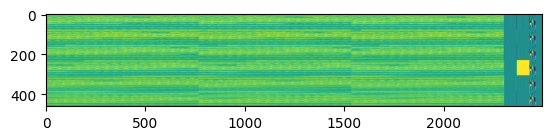

In [32]:
plt.imshow(patch_coded_element[0,:,:])

In [33]:
loss, reconstruction = perceiver_ae(patch_coded_element, return_prediction=True)

Input tensor shape:  (1, 462, 2495)
Spacetime codes shape:  (1, 462, 191)
Prediction shape:  (1, 462, 2304)


2022-10-20 18:51:38.820808: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Exception encountered when calling layer "perceiver_ae" "                 f"(type PerceiverAE).

{{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:SquaredDifference]

Call arguments received by layer "perceiver_ae" "                 f"(type PerceiverAE):
  • reconstruct_me=tf.Tensor(shape=(1, 462, 2495), dtype=float32)
  • reset_latent=True
  • return_prediction=True

In [34]:
x = tf.random.uniform([1, 462, 2495])

In [ ]:
x